<a href="https://colab.research.google.com/github/massirism/Codes/blob/main/prueba_knowledge_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import torch
from torch import nn
from torch.autograd import Variable


#import the required packages
import requests
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class Topic():
  def __init__(self,name):
    self.name=name;
    #self.lista[] #Posible lista de papers.
  
  def muestra(self):
    print("El nombre del topic es: "+self.name)


class Paper():
  def __init__(self,title,abstract,link):
    self.title=title
    self.abstract=abstract
    self.url=link
    #self.list_words=[]  #Lista de tuplas (palabra,porcentaje)

  def ProbWord(self):
    text=self.abstract
    token=re.findall('\w+', text) #Tokenizo el texto
    #token[:10]

    words=[]
    for word in token:
      words.append(word.lower())    #Guardo el texto tokenizado en una lista de palabras
    #words[:8]

    nltk.download("stopwords")      #Descargo las stopwords
    # remove stop words
    sw=nltk.corpus.stopwords.words('english') #Están guardadas las stop words
    #sw[:5]

    words_ne=[]
    for word in words:
        if word not in sw:
             words_ne.append(word)    #Al texto le saco las stop words
    #words_ne[:5]    #Ya el texto sin stop words

    fdist_filtered = nltk.FreqDist(words_ne)  #Ya el texto filterado
    n_words=10
    sns.set_style('darkgrid')
    fdist_filtered.plot(n_words,title='Frequency distribution for '+str(n_words)+' most common tokens in our text collection (excluding stopwords and punctuation)')
    return(fdist_filtered)

  def muestra(self):
    print("Titulo: "+ self.title+"\n"+"Abstract: "+self.abstract+"\n"+ "url: "+self.url)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


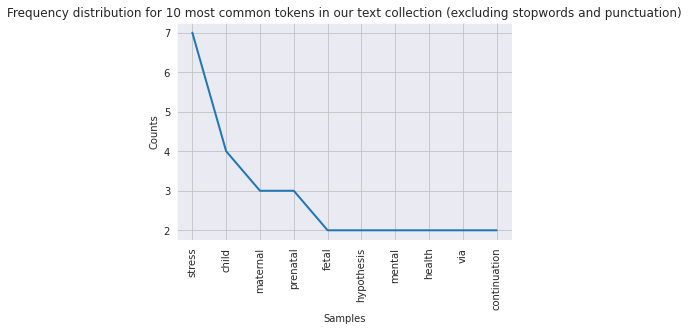

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


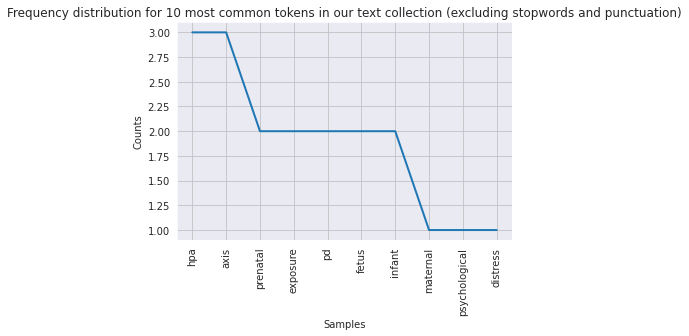

In [25]:
#Crep el paper "a"
pa=Paper("hola","The cat sat on my face","www.HOLA.COM")
#pa.muestra()
#pa.ProbWord()

pb=Paper("Adios","The dog sat on my bed","www.ADIOS.com")
#pb.muestra()
#pb.ProbWord()

abstract1="This study utilized a developmental cascade approach to test alternative theories about the underlying mechanisms behind the association of maternal prenatal stress and child psychopathology. The fetal programming hypothesis suggests that prenatal stress affects fetal structural and physiological systems responsible for individual differences in child temperament, which further increases risk for internalizing and externalizing problems. Interpersonal models of stress transmission suggest that maternal stress influences child mental health via early parenting behaviors. We also examined a continuation of stress hypothesis, in which prenatal stress predicts child mental health via the continuation of maternal stress in the postpartum period."
title1="A Developmental Cascade from Prenatal Stress to Child Internalizing and Externalizing Problems."
url1="https://www.ncbi.nlm.nih.gov/pubmed/31166597"


title2="Prenatal maternal distress associates with a blunted cortisol response in rhinovirus-positive infants."
abstract2="Prenatal exposure to maternal psychological distress (PD) may have programming effects on the fetus/infant hypothalamic-pituitary-adrenal (HPA) axis and subsequently on the development of the fetus' immune function. Therefore, our aim was to study whether prenatal exposure to PD is related to early infant HPA axis reactivity in the context of a subclinical rhinovirus infection that challenges infants HPA axis postnatally."
url2="https://www.ncbi.nlm.nih.gov/pubmed/31146139"


p1=Paper(title1,abstract1,url1)
p2=Paper(title2,abstract2,url2)

#Un poco de análisis de texto del abstract
p1.ProbWord()
p2.ProbWord()

#Creo los topic
topic1=Topic("Cancer")
#topic.muestra()
topic2=Topic("Fútbol")

In [26]:
graph = [
     # <subject, predicate, object>
   # ("topics","is_topic","topic_1") #Esto será tomado en cuenta en el momento que tenga una super clase que tenga todos los tópicos
    (topic1,"is_paper",pa), #Tendría problema porque lo estoy armando yo, tendría que saber cuantos papers hay si quisiera hacerlo automático
    (topic1,"is_paper",pb), #Se podrá ver después porque creo que este código lo uniré al playground que hizo Pablo
    (topic2,"is_paper",p1),
    (topic2,"is_paper",p2)


]

In [15]:
class KnowledgeGraphEmbeddings(nn.Module):
    def __init__(self, graph, embedding_size = 3):
        super(KnowledgeGraphEmbeddings, self).__init__()
        
        entities = []
        relations = []
        for fact in graph:
            source, relation, target = fact[0], fact[1], fact[2]
            entities.append(source)
            entities.append(target)
            relations.append(relation)

        self.entities = list(set(entities))
        self.relations = list(set(relations))
        self.entities2id = { ent:i for i, ent in enumerate(self.entities) } 
        self.relations2id = { rel:i for i, rel in enumerate(self.relations) } 
        
        self.entity_embeddings = nn.Embedding(len(self.entities2id), embedding_size)
        self.relation_embeddings = nn.Embedding(len(self.relations2id), embedding_size)
        self.graph = graph
        
        #Se etrena con relaciones que si existen!
    def positive(self, fact):
        source, relation, target = fact[0], fact[1], fact[2]
        source_id = self.entities2id[source]
        target_id = self.entities2id[target]
        relation_id = self.relations2id[relation]
        
        source_id = Variable(torch.LongTensor([source_id])).view(1, -1)
        target_id = Variable(torch.LongTensor([target_id])).view(1, -1)
        relation_id = Variable(torch.LongTensor([relation_id])).view(1, -1)

        source_embedding = self.entity_embeddings(source_id)
        target_embedding = self.entity_embeddings(target_id)
        relation_embedding = self.entity_embeddings(relation_id)
        score = torch.dist(source_embedding + relation_embedding, target_embedding)
        #print('positive', source, relation, target, score.data[0])
        return score
    

    #Relaciones que no existen, por ejemplo la relación entre los papers.
    def negative(self):
        # Sample until we find an invalid fact
        while True:
            random_source_id = random.randint(0, len(self.entities2id) - 1)
            random_relation_id = random.randint(0, len(self.relations2id) - 1)
            random_target_id = random.randint(0, len(self.entities2id) - 1)
            
            source = self.entities[random_source_id]
            target = self.entities[random_target_id]
            relation = self.relations[random_relation_id]
            if (source, relation, target) not in graph:
                break
        
        source_id = Variable(torch.LongTensor([random_source_id])).view(1, -1)
        relation_id = Variable(torch.LongTensor([random_relation_id])).view(1, -1)
        target_id = Variable(torch.LongTensor([random_target_id])).view(1, -1)
        
        source_embedding = self.entity_embeddings(source_id)
        relation_embedding = self.entity_embeddings(relation_id)
        target_embedding = self.entity_embeddings(target_id)
        
        score = torch.dist(source_embedding + relation_embedding, target_embedding)
        #print('negative', self.entities[random_source_id], self.relations[random_relation_id], self.entities[random_target_id], score.data[0])
        return score

    def forward(self, fact, margin=1.0):
        positive_score = self.positive(fact)
        negative_score = self.negative()
        loss = torch.max((positive_score - negative_score + margin).sum(), Variable(torch.FloatTensor([0])))
        #print('%.2f - %.2f + %.2f = %.2f' %(positive_score.data[0], negative_score.data[0], margin, loss.data[0]))

        return loss
    
    def score(self, fact):
        return self.positive(fact)




In [6]:
#La idea es entrenar con relaciones
#Despues veo el score que arrojan.
def train(fact, embedding_model, optimizer):
    avg_loss = 0.
    # 10 training cycles for this fact, with negative sampling
    for i in range(len(embedding_model.entities) * len(embedding_model.entities) * len(embedding_model.relations)):
        embedding_model.zero_grad()
        loss = embedding_model(fact)
        loss.backward()
        optimizer.step()
        avg_loss += loss.data[0]
    return avg_loss / 10

In [27]:
embedding_model = KnowledgeGraphEmbeddings(graph)
optimizer = torch.optim.Adam(embedding_model.parameters(), lr=0.001)
losses = []
epochs = 50
for e in range(epochs):
    total_loss = 0.
    for fact in graph:
        loss = train(fact, embedding_model, optimizer)
        total_loss += loss
    losses.append(total_loss)

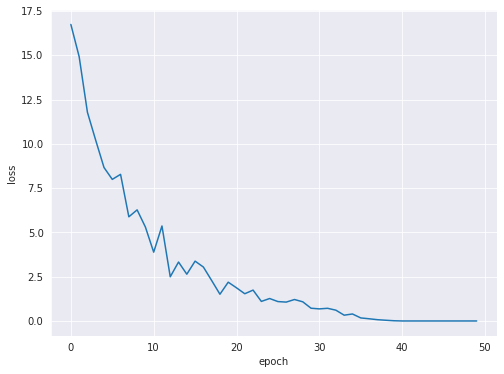

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6),)
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss');

In [31]:
#LOS CRUZO
print(embedding_model.score((topic2,'is_paper',pa)))
print(embedding_model.score((topic2,'is_paper',pb)))

print(embedding_model.score((topic1,'is_paper',p1)))
print(embedding_model.score((topic1,'is_paper',p2)))

print("COMO VAN")

#Ahora si como van
print(embedding_model.score((topic1,'is_paper',pa)))
print(embedding_model.score((topic1,'is_paper',pb)))


print(embedding_model.score((topic2,'is_paper',p1)))
print(embedding_model.score((topic2,'is_paper',p2)))

#(recuerde, de acuerdo con nuestra formulación, una puntuación más baja = más probable).
# Link donde saqué Knowledge Graph Inference with Neural Embeddings:
#     https://m.mage.ai/knowledge-graph-inference-with-neural-embeddings-412c85da7f1b
#     El repo: https://github.com/czhu12/blogexamples/blob/master/knowledge_graph_embeddings.ipynb


tensor(3.1057, grad_fn=<DistBackward0>)
tensor(3.1977, grad_fn=<DistBackward0>)
tensor(3.0849, grad_fn=<DistBackward0>)
tensor(2.9718, grad_fn=<DistBackward0>)
COMO VAN
tensor(0.1842, grad_fn=<DistBackward0>)
tensor(0.1827, grad_fn=<DistBackward0>)
tensor(0.1855, grad_fn=<DistBackward0>)
tensor(0.1704, grad_fn=<DistBackward0>)
